In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

pd.options.mode.chained_assignment = None  # Suppress the warning

In [23]:
df_T=pd.read_csv('data/batch_no2/raw data/Jun 2, 2023_8 36 21 AM_DTU 3-parameterValues_Temperature_Value.csv', sep=';')
df_stir=pd.read_csv('data/batch_no2/raw data/Jun 2, 2023_8 36 21 AM_DTU 3-parameterValues_Stirrer_Value.csv', sep=';')
df_feed1=pd.read_csv('data/batch_no2/raw data/Jun 2, 2023_8 36 21 AM_DTU 3-parameterValues_Feed 1_Value.csv', sep=';')
df_base=pd.read_csv('data/batch_no2/raw data/Jun 2, 2023_8 36 21 AM_DTU 3-parameterValues_Pump - Base_Value.csv', sep=';')
df_acid=pd.read_csv('data/batch_no2/raw data/Jun 2, 2023_8 36 21 AM_DTU 3-parameterValues_Pump - Acid_Value.csv', sep=';')
df_pO2=pd.read_csv('data/batch_no2/raw data/Jun 2, 2023_8 36 21 AM_DTU 3-parameterValues_pO₂_Value.csv', sep=';')
df_pH=pd.read_csv('data/batch_no2/raw data/Jun 2, 2023_8 36 21 AM_DTU 3-parameterValues_pH_Value.csv', sep=';')
df_air=pd.read_csv('data/batch_no2/raw data/Jun 2, 2023_8 36 21 AM_DTU 3-parameterValues_Flow - Air_Value.csv', sep=';')
df_offgas = pd.read_excel('data/batch_no2/raw data/offgas_data.xlsx')
df_X_S = pd.read_csv('data/batch_no2/raw data/offline_data.csv', sep=';')
df_S_extract = pd.read_excel('data/batch_no2/raw data/data_S_sensor_extracted.xlsx')
df_S_smoothed = pd.read_excel('data/batch_no2/raw data/data_S_sensor_smoothed.xlsx')
df_S_calibrated1= pd.read_excel('data/batch_no2/raw data/data_S_sensor_calibrated.xlsx')
df_S_hplc = pd.read_csv('data/batch_no2/raw data/data_S_hplc.csv', sep=';')

In [3]:
first_para=[df_T, df_stir, df_feed1, df_pO2, df_pH, df_air]
second_para=[df_base, df_acid]

In [4]:
start = '12-07-2023 19:00:00' # eig. 12-07-2023 18:30:00  --> der Biostream tower hatte Uhrzeit die ne halbe stunde vor ging
end = '14-07-2023 10:00:00' # eig. 14-07-2023 07:30
start_time = datetime.strptime(start, '%d-%m-%Y %H:%M:%S')
end_time = datetime.strptime(end, '%d-%m-%Y %H:%M:%S')

In [5]:
# dataframes are prepared to be merged into one dataframe based on the timestamp
df_merged1=pd.DataFrame()

for df in first_para:
    df_copy=df.copy()
    # convert the timestamp into the datetime format and drop the original timestamp
    df_copy.insert(0, 'DateTime', df_copy['Date'].astype(str)+' '+df_copy['Time'].astype(str))
    df_copy.drop(['Date', 'Time'], axis=1, inplace=True)
    df_copy['DateTime']=pd.to_datetime(df_copy['DateTime'], format='%b %d, %Y %I:%M:%S %p')

    # values are converted to floats
    df_copy[df_copy.columns[1]]=df_copy[df_copy.columns[1]].str.replace(',', '.')
    df_copy[df_copy.columns[1]]=pd.to_numeric(df_copy[df_copy.columns[1]], errors='coerce')

    # reduce sample frequency to 1min which makes the merge easier
    ## mean value of each minute is taken
    df_copy.set_index('DateTime', inplace=True)
    df_resampled = df_copy.resample('1T').mean() # could be changed to sum/first/min/max...
    df_resampled = df_resampled.reset_index()
    
    # dataframe is reduced to the start and end time of the fermentation
    df_se=df_resampled[(df_resampled['DateTime'] > start_time) & (df_resampled['DateTime'] < end_time)]
    df_se = df_se.reset_index(drop=True)
    if df_merged1.empty:
        df_merged1=df_se
    else:
        df_merged1=df_merged1.merge(df_se, on='DateTime', how='inner')

Second parameter group (sum for reduction of sampling frequency):

In [6]:
# dataframes are prepared to be merged into one dataframe based on the timestamp
# since the feed of base/acid lasts only 5s, data will be lost if we take the first value
## instead we take the sum of the values within that minute and then later divide it by (5/60)
df_merged2=pd.DataFrame()

for df in second_para:
    df_copy=df.copy()
    # convert the timestamp into the datetime format and drop the original timestamp
    df_copy.insert(0, 'DateTime', df_copy['Date'].astype(str)+' '+df_copy['Time'].astype(str))
    df_copy.drop(['Date', 'Time'], axis=1, inplace=True)
    df_copy['DateTime']=pd.to_datetime(df_copy['DateTime'], format='%b %d, %Y %I:%M:%S %p')

    # values are converted to floats
    df_copy[df_copy.columns[1]]=df_copy[df_copy.columns[1]].str.replace(',', '.')
    df_copy[df_copy.columns[1]]=pd.to_numeric(df_copy[df_copy.columns[1]], errors='coerce')

    # reduce sample frequency to 1min which makes the merge easier
    ## mean value of each minute is taken
    df_copy.set_index('DateTime', inplace=True)
    df_resampled = df_copy.resample('1T').sum() # could be changed to sum/mean/first/min/max...
    df_resampled = df_resampled.reset_index()
    
    # dataframe is reduced to the start and end time of the fermentation
    df_se=df_resampled[(df_resampled['DateTime'] > start_time) & (df_resampled['DateTime'] < end_time)]
    df_se = df_se.reset_index(drop=True)
    if df_merged2.empty:
        df_merged2=df_se
    else:
        df_merged2=df_merged2.merge(df_se, on='DateTime', how='inner')

In [7]:
# merging the 2 dataframes
df_merged3 = df_merged1.copy()
df_merged3 = df_merged3.merge(df_merged2, on='DateTime', how='inner')

Merge offgas to the other parameters.

In [8]:
# offgas values are saved in another dataframe
## same preprocessing as the others

# methanol is zero for the whole time period and RMS is not needed
## ethanol has 30 not zero values but the highest is 0.0001 %
df_offgas.drop(['time [h]'], axis=1, inplace=True) #
# reduce sample frequency to 1min which makes the merge easier
## mean value of each minute is taken
df_offgas.set_index('Time&Date', inplace=True)
df_resampled = df_offgas.resample('1T').mean() # could be changed to sum/mean/first/min/max...
df_resampled.reset_index(drop=False, inplace=True)
df_resampled.rename(columns={'Time&Date': 'DateTime'}, inplace=True)

# dataframe is reduced to the start and end time of the fermentation
df_offg=df_resampled[(df_resampled['DateTime'] > start_time) & (df_resampled['DateTime'] < end_time)]

In [10]:
# add process duration in hours as time [h]
df_merged4=df_merged3.merge(df_offg, on='DateTime', how='inner')
first_timestamp = df_merged4['DateTime'].iloc[0]  # Get the first timestamp
df_merged4['time [h]'] = (df_merged4['DateTime'] - first_timestamp) / pd.Timedelta(hours=1)
df_merged4['time [h]'] = df_merged4['time [h]'].round(2)
df_merged4.rename(columns={'Temperature Value (°C)': 'Temperature [°C]', 'Stirrer Value (rpm)': 'Stirrer [rpm]', 'pO₂ Value (pO₂)': 'DO2 [%]'}, errors='raise', inplace=True)
df_merged4.rename(columns={'CO2 [%]': 'Offgas CO2 [%]', 'O2 [%]': 'Offgas O2 [%]'}, errors='raise', inplace=True)
df_merged4.head(1)

,DateTime,Temperature [°C],Stirrer [rpm],Feed 1 Value (%),DO2 [%],pH Value (pH),Flow - Air Value,Pump - Base Value (%),Pump - Acid Value (%),Offgas O2 [%],Offgas CO2 [%],time [h]
0,2023-07-12 19:01:00,29.902727,193.487273,0.0,79.528,6.94,0.0,0.0,0.0,NaN,NaN,0.0


Merge biomass to the other parameters.

In [20]:
df_biomass = df_X_S[['time [h]', 'BM (g/l)']]
for col in df_biomass.columns:
    df_biomass[col]=df_biomass[col].str.replace(',', '.')
    df_biomass[col]=pd.to_numeric(df_biomass[col])
df_biomass.rename(columns={'BM (g/l)': 'Biomass [g/L]'}, inplace=True)
df_biomass.head(1)

,time [h],Biomass [g/L]
0,0.75,0.38


Merge HPLC data for glucose, lactic acid, acetic acid and ehtanol to other paramters.

In [27]:
df_hplc = df_S_hplc[['time [h]', 'glucose [g/l] ']]
for col in df_hplc.columns:
     df_hplc[col] = df_hplc[col].str.replace(',', '.')
     df_hplc[col] = pd.to_numeric(df_hplc[col])
df_hplc.rename(columns={'glucose [g/l] ': 'Glucose hplc [g/L]'}, inplace=True)
# the hplc measurements were diluted with XXX in a 1:1 ratio
## therefore all values have to be multiplied by 2
# df_hplc.iloc[:, 1:5] *= 2
df_hplc.tail(2)

,time [h],Glucose hplc [g/L]
11,23.50,0.41
12,35.75,0.37


In [28]:
# merging the biomass data with the hplc data
df_Yxs = df_biomass.merge(df_hplc, on='time [h]', how='left')

# Save the DataFrame to an Excel file
df_Yxs.to_csv('data/batch_no2/Yxs_table.csv', index=False)
df_Yxs.head(1)

,time [h],Biomass [g/L],Glucose hplc [g/L]
0,0.75,0.38,0.95


In [29]:
# merging the biomass, substrates and coefficients to the overall dataframe
df = df_merged4.merge(df_Yxs, on='time [h]', how='left')
df.head(1)

,DateTime,Temperature [°C],Stirrer [rpm],Feed 1 Value (%),DO2 [%],pH Value (pH),Flow - Air Value,Pump - Base Value (%),Pump - Acid Value (%),Offgas O2 [%],Offgas CO2 [%],time [h],Biomass [g/L],Glucose hplc [g/L]
0,2023-07-12 19:01:00,29.902727,193.487273,0.0,79.528,6.94,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN


##### 3. Calculation of process parameters

In [188]:
df['Feed 1 Value (ml/min)'] = df['Feed 1 Value (%)']*0.11

#### Smoothing

In [189]:
df['Stirrer Value (rpm) - smoothed'] = df['Stirrer Value (rpm)'].ewm(alpha=0.01).mean()
df['pO₂ Value (pO₂) - smoothed'] = df['pO₂ Value (pO₂)'].ewm(alpha=0.01).mean()



In [190]:
df_Sensor['pre fermentation [Ampere] - smoothed1'] = df_Sensor['pre fermentation [Ampere]'].ewm(alpha=0.01).mean()
df_Sensor['fermentation [Ampere] - smoothed2'] = df_Sensor['fermentation [Ampere]'].ewm(alpha=0.01).mean()
df_Sensor.head(1)



,time [h],pre fermentation [Ampere],time [s],fermentation [Ampere],time [h].1,pre fermentation [Ampere] - smoothed1,fermentation [Ampere] - smoothed2
0,0,17.523766,0,0.452995,NaN,17.523766,0.452995


#### outlier deletion 

In [191]:
# Create a new column with filtered values and zeros for deleted values
df['Filtered Feed 1 Value'] = df['Feed 1 Value (ml/min)'].where(df['Feed 1 Value (ml/min)'] <= 1, other=0)

# Reset the index if desired
df.reset_index(drop=True, inplace=True)

In [192]:
# REAL Feed ingoing 
# Create a new column with filtered values
df['real Feed'] = df['Filtered Feed 1 Value']

# Set values before time of 20 hours to zero
df.loc[df['time [h]'] < 20.1, 'real Feed'] = 0

# Reset the index if desired
df.reset_index(drop=True, inplace=True)

#### Offgas CO2 and O2 

In [193]:
import datetime

# Create a range of time values from 0 to 36.9 hours with 10-minute intervals
start_time = datetime.datetime.strptime('00:00:00', '%H:%M:%S')
end_time = start_time + datetime.timedelta(hours=36, minutes=54)
time_values = pd.date_range(start=start_time, end=end_time, freq='10T').time

# Slice the time values to match the desired number of rows (1636 rows)
time_values = time_values[:1636]
num_rows = 1636
time_values = np.linspace(0, 36.9, num_rows)

# Reindex the time values to match the DataFrame's length
time_values = pd.Series(time_values).reindex(range(len(df_Offgas)))


# Assign the time values to the "Time" column in the DataFrame
df_Offgas['Time [h]'] = time_values

In [194]:
df_Offgas.head(1)

,Time&Date,O2 [%],CO2 [%],time [h],Time [h]
0,2023-07-12 17:18:17.050,21.0931,0.0501,0.0,0.0


### calculating the volume based on the exponential equations / df_offgas

In [195]:
df_Offgas['Volume [L]'] = 4.0  # Initialize the entire 'Volume [L]' column with 4.0 L

# Find rows where 'Time [h]' is between 20 and 25 (inclusive)
condition = (df_Offgas['Time [h]'] >= 20) & (df_Offgas['Time [h]'] <= 25)

# Apply the exponential feeding equation only to the selected rows
df_Offgas.loc[condition, 'Volume [L]'] = 4.0 + (16.4/1000 * np.exp(0.10 * df_Offgas.loc[condition, 'Time [h]']))


condition1 = (df_Offgas['Time [h]'] >= 25) & (df_Offgas['Time [h]'] <= 36.9)

# Apply the exponential feeding equation only to the selected rows
df_Offgas.loc[condition1, 'Volume [L]'] =df_Offgas['Volume [L]'].iloc[1107] + (17.4/1000 * np.exp(0.07 * df_Offgas.loc[condition1, 'Time [h]']))


In [196]:
df_Offgas['CER [%/L/h]'] = ((df_Offgas['CO2 [%]']-df_Offgas['CO2 [%]'][0])/df_Offgas['Volume [L]'])/(df_Offgas['Time [h]'])
df_Offgas['OUR [%/L/h]'] = ((df_Offgas['O2 [%]']-df_Offgas['O2 [%]'][0])/df_Offgas['Volume [L]'])/(df_Offgas['Time [h]'])
df_Offgas['RQ'] = (df_Offgas['CER [%/L/h]'] / df_Offgas['OUR [%/L/h]'])*(-1)
df_Offgas.head(2)

,Time&Date,O2 [%],CO2 [%],time [h],Time [h],Volume [L],CER [%/L/h],OUR [%/L/h],RQ
0,2023-07-12 17:18:17.050,21.0931,0.0501,0.00,0.000000,4.0,NaN,NaN,NaN
1,2023-07-12 17:19:45.950,21.0935,0.0497,0.02,0.022569,4.0,-0.004431,0.004431,1.0


#### New  CSV- Data frame 

In [197]:
# save dataframe as csv and xlsx files
df.to_csv('data_combined.csv')
df.to_excel('data_combined.xlsx')
df_Sensor.to_excel('data_sensor.xlsx')

In [199]:
df.head()

,DateTime,Temperature Value (°C),Stirrer Value (rpm),Feed 1 Value (%),pO₂ Value (pO₂),pH Value (pH),Flow - Air Value,time [h],BM (g/l),Glucose addition (g),glucose [g/l],Feed 1 Value (ml/min),Stirrer Value (rpm) - smoothed,pO₂ Value (pO₂) - smoothed,Filtered Feed 1 Value,real Feed
0,2023-07-12 19:01:00,29.902727,193.487273,0.0,79.528000,6.940000,0.0,0.00,NaN,NaN,NaN,0.0,193.487273,79.528000,0.0,0.0
1,2023-07-12 19:02:00,29.885455,193.840000,0.0,79.088571,6.936250,0.0,0.02,NaN,NaN,NaN,0.0,193.664523,79.307182,0.0,0.0
2,2023-07-12 19:03:00,29.872308,193.575000,0.0,77.798333,6.920000,0.0,0.03,NaN,NaN,NaN,0.0,193.634381,78.799169,0.0,0.0
3,2023-07-12 19:04:00,29.850000,193.225000,0.0,74.970000,6.920000,0.0,0.05,NaN,NaN,NaN,0.0,193.530488,77.827397,0.0,0.0
4,2023-07-12 19:05:00,29.860909,193.664167,0.0,72.260000,6.914444,0.0,0.07,NaN,NaN,NaN,0.0,193.557764,76.691424,0.0,0.0


In [200]:
df_Sensor_smoothed['Current to Concentration'] = df_Sensor_smoothed['fermentation [Ampere] - smoothed2']*735.29

df_Sensor_smoothed['Current to Concentration-smoothed'] = df_Sensor_smoothed['Current to Concentration'].ewm(alpha=0.1).mean()

df_Sensor_calibrated = df_Sensor_smoothed['Current to Concentration-smoothed']

df_Sensor_smoothed.to_excel(('data_sensor_converted.xlsx'))

df_Sensor_smoothed.head(1)

,Unnamed: 0,time [h],pre fermentation [Ampere],time [s],fermentation [Ampere],time [h].1,pre fermentation [Ampere] - smoothed1,fermentation [Ampere] - smoothed2,Current to Concentration,Current to Concentration-smoothed
0,0,0,17.523766,0,0.452995,NaN,17.523766,0.452995,333.082914,333.082914


In [201]:
df_Sensor_smoothed['Time[h]'] = (df_Sensor_smoothed['time [s]'])/60/60
df_Sensor_smoothed.head(3)

,Unnamed: 0,time [h],pre fermentation [Ampere],time [s],fermentation [Ampere],time [h].1,pre fermentation [Ampere] - smoothed1,fermentation [Ampere] - smoothed2,Current to Concentration,Current to Concentration-smoothed,Time[h]
0,0,0,17.523766,0,0.452995,NaN,17.523766,0.452995,333.082914,333.082914,0.000000
1,1,6,0.707319,6,0.031340,NaN,9.073290,0.241108,177.284558,251.083779,0.001667
2,2,12,0.439050,12,0.025160,NaN,6.166236,0.168401,123.823610,204.124307,0.003333


In [202]:
df_Sensor_smoothed.head(1)

,Unnamed: 0,time [h],pre fermentation [Ampere],time [s],fermentation [Ampere],time [h].1,pre fermentation [Ampere] - smoothed1,fermentation [Ampere] - smoothed2,Current to Concentration,Current to Concentration-smoothed,Time[h]
0,0,0,17.523766,0,0.452995,NaN,17.523766,0.452995,333.082914,333.082914,0.0


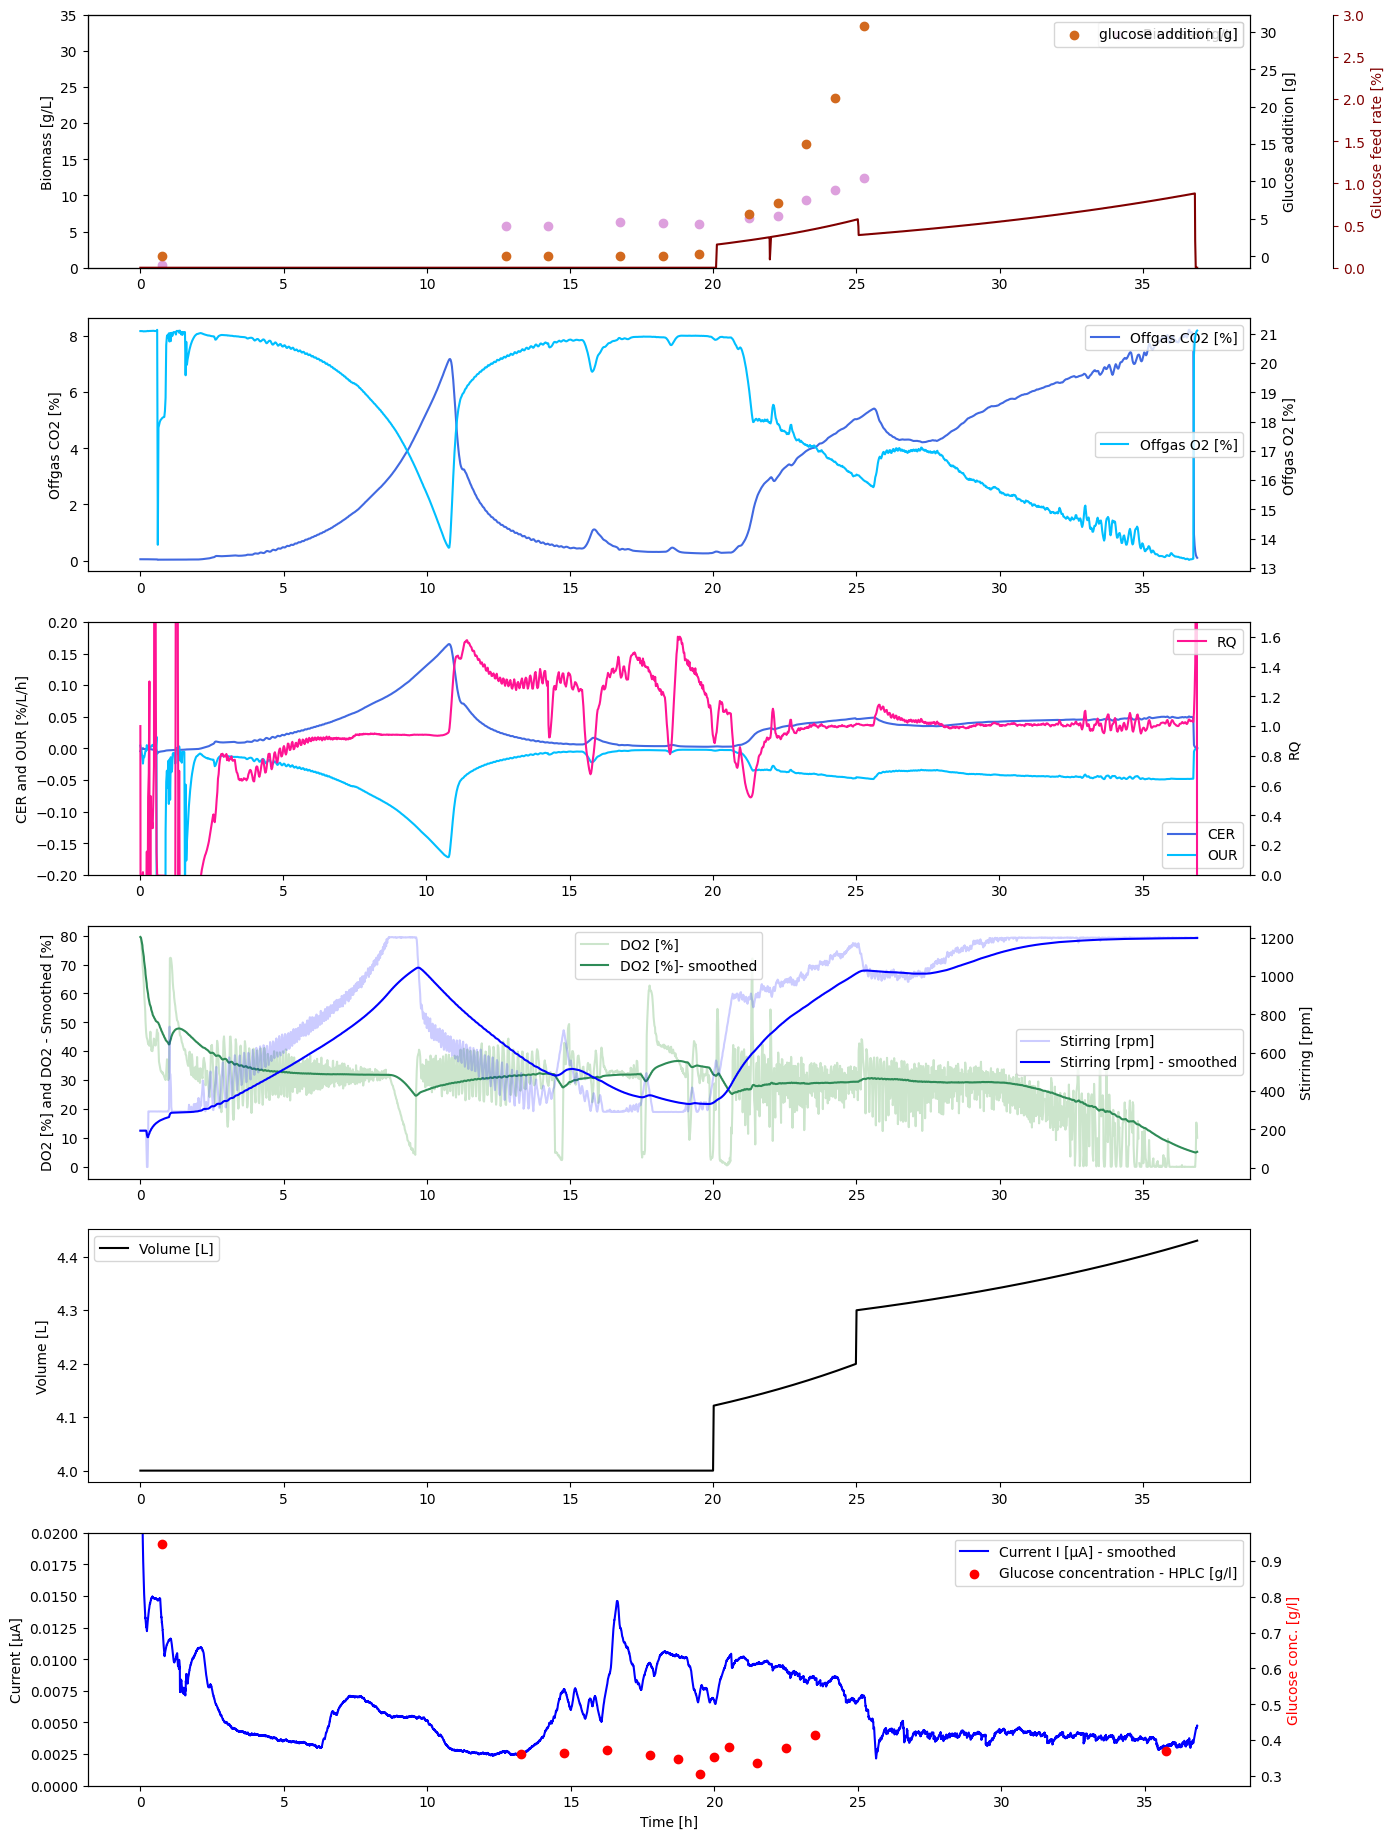

In [203]:
fig, ax = plt.subplots(6,1, figsize=(15,23))

# Assuming you have already created the 'ax' object as an array of subplots

# 1) Biomass and Glucose Addition
ax[0].scatter(df['time [h]'], df['BM (g/l)'], label='Biomass [g/L]', color='plum')
ax0 = ax[0].twinx()
ax0.scatter(df['time [h]'], df[' Glucose addition (g) '], label='glucose addition [g]', color='chocolate')

# Add the third y-axis for Glucose feed rate
ax0_2 = ax[0].twinx()
ax0_2.spines['right'].set_position(('outward', 60))  # Position the third axis to the right
ax0_2.plot(df['time [h]'], df['real Feed'], label='Glucose feed rate [%]', color='maroon')
ax0_2.set_ylim(0, 3)  
ax0_2.set_ylabel('Glucose feed rate [%]')
ax0_2.yaxis.label.set_color('maroon')  # Set the label color to match the plot color
ax0_2.tick_params(axis='y', colors='maroon')  # Set the tick color to match the plot color

ax[0].set_ylabel('Biomass [g/L]')
ax[0].set_ylim(0,35)
ax0.set_ylabel('Glucose addition [g]')
ax[0].legend(loc='upper right')
ax0.legend(loc='best')

# 2) Offgas CO2 and O2
ax[1].plot(df_Offgas['Time [h]'], df_Offgas['CO2 [%]'], label='Offgas CO2 [%]', color='royalblue')
ax1 = ax[1].twinx()
ax1.plot(df_Offgas['Time [h]'], df_Offgas['O2 [%]'], label='Offgas O2 [%]', color='deepskyblue')

ax[1].set_ylabel('Offgas CO2 [%]')
ax1.set_ylabel('Offgas O2 [%]')
ax[1].legend(loc='upper right')
ax1.legend(loc='right')

# 3) CER, OUR, and RQ
ax[2].plot(df_Offgas['Time [h]'], df_Offgas['CER [%/L/h]'], label='CER', color='royalblue')
ax[2].plot(df_Offgas['Time [h]'], df_Offgas['OUR [%/L/h]'], label='OUR', color='deepskyblue')
ax2 = ax[2].twinx()
ax2.plot(df_Offgas['Time [h]'], df_Offgas['RQ'], label='RQ', color='deeppink')

ax[2].set_ylabel('CER and OUR [%/L/h]')#
ax[2].set_ylim(-0.2,0.2)
ax2.set_ylabel('RQ')
ax2.set_ylim(0,1.7)
ax[2].legend(loc='lower right')
ax2.legend(loc='upper right')

# 4) pO2 and Stirring
ax[3].plot(df['time [h]'], df['pO₂ Value (pO₂)'], label='DO2 [%]', color='green', alpha=0.2)
ax[3].plot(df['time [h]'], df['pO₂ Value (pO₂) - smoothed'], label='DO2 [%]- smoothed', color='seagreen')
ax3 = ax[3].twinx()
ax3.plot(df['time [h]'], df['Stirrer Value (rpm)'], label='Stirring [rpm]', color='blue', alpha=0.2)
ax3.plot(df['time [h]'], df['Stirrer Value (rpm) - smoothed'], label='Stirring [rpm] - smoothed', color='blue')

ax[3].set_ylabel('DO2 [%] and DO2 - Smoothed [%]')
ax3.set_ylabel('Stirring [rpm]')
ax[3].legend(loc='upper center')
ax3.legend(loc='right')

# 5) Offgas Volume
ax[4].plot(df_Offgas['Time [h]'], df_Offgas['Volume [L]'], label='Volume [L]', color='black')


ax[4].set_ylabel('Volume [L]')
ax[4].legend(loc='upper left')
# No need to add legend for the second axis since it's empty



ax5 = ax[5].twinx()


# Define the plots with labels for each dataset
ax[5].plot(df_Sensor_smoothed['Time[h]'], df_Sensor_smoothed['fermentation [Ampere] - smoothed2'],
           label='Current I [μA] - smoothed', color='blue')
ax5.scatter(df['time [h]'], df['glucose [g/l] '], color='red', label='Glucose concentration - HPLC [g/l]')

# Set the y-axis labels for both axes
ax[5].set_ylabel('Current [μA]')
ax5.set_ylabel('Glucose conc. [g/l]', color='red')

# Set the shared x-axis label for both axes
ax[5].set_xlabel('Time [h]')

# Set the y-axis limits for ax[5]
ax[5].set_ylim(0, 0.02)

# Retrieve the handles and labels from both legends
handles1, labels1 = ax[5].get_legend_handles_labels()
handles2, labels2 = ax5.get_legend_handles_labels()

# Combine the handles and labels from both legends
combined_handles = handles1 + handles2
combined_labels = labels1 + labels2

# Plot the combined legend
ax[5].legend(combined_handles, combined_labels, loc='upper right')


plt.show()


In [211]:
df_BM_glc.head(1) 

,Sample,time (min),time [h],OD600_diluted,OD600_,BM (g/l),Glucose feed (ml),Glucose addition (g),Peak area,concentration g/l,1:10 concentration g/l,1:1 concentration g/l,mu ( log),Yxs,qs
0,1.0,45.0,0.75,0.113,1.13,0.376667,0.0,0.0,4.177,0.439266,0.946926,9.469259,0.948118,0.0,0.0


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

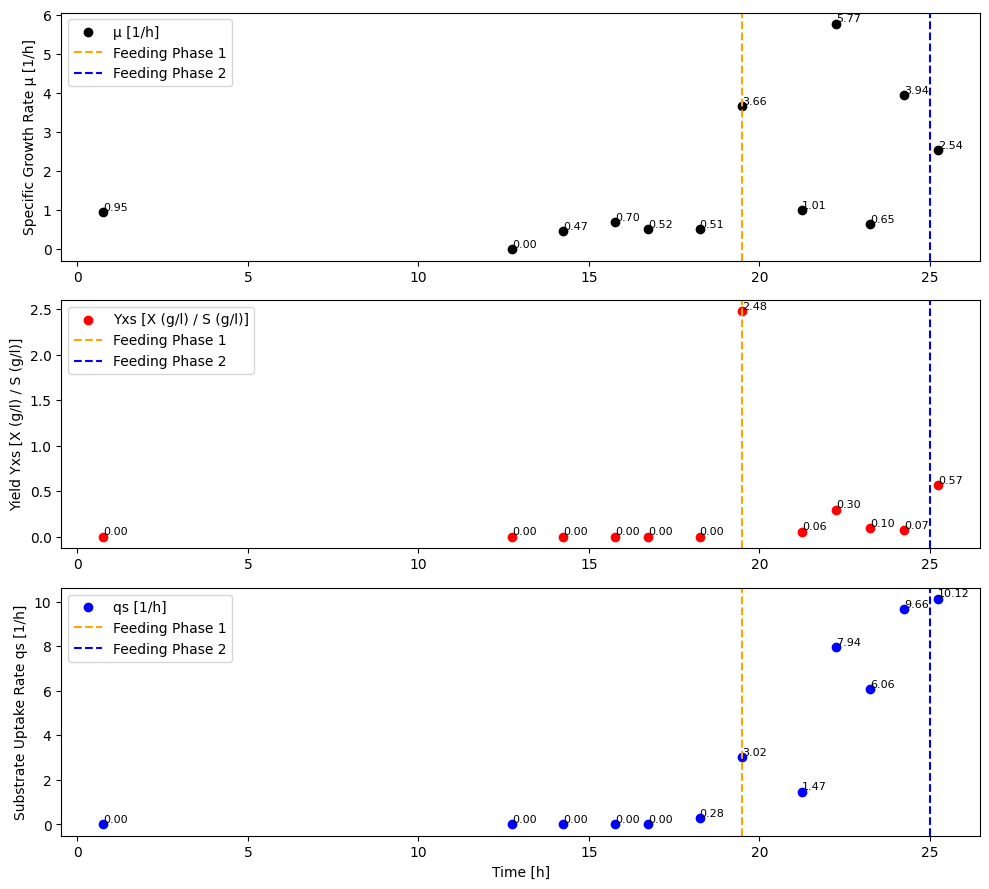

In [237]:


fig, ax = plt.subplots(3, 1, figsize=(10, 9))


# Assuming you already have the 'ax' objects and data loaded (as shown in the initial code snippet)

# Subplot 1
ax[0].scatter(df_BM_glc['time [h]'], df_BM_glc['mu ( log)'], label='μ [1/h]', color='black')
ax[0].set_ylabel('Specific Growth Rate μ [1/h]')

for x, y in zip(df_BM_glc['time [h]'], df_BM_glc['mu ( log)']):
    ax[0].text(x, y, f'{y:.2f}', ha='left', va='bottom', fontsize=8)

# Add vertical lines for feeding phases
ax[0].axvline(x=19.5, color='orange', linestyle='--', label='Feeding Phase 1')
ax[0].axvline(x=25, color='blue', linestyle='--', label='Feeding Phase 2')

# Subplot 2
ax[1].scatter(df_BM_glc['time [h]'], df_BM_glc['Yxs'], label='Yxs [X (g/l) / S (g/l)]', color='red')
ax[1].set_ylabel('Yield Yxs [X (g/l) / S (g/l)]')

for x, y in zip(df_BM_glc['time [h]'], df_BM_glc['Yxs']):
    ax[1].text(x, y, f'{y:.2f}', ha='left', va='bottom', fontsize=8)

# Add vertical lines for feeding phases
ax[1].axvline(x=19.5, color='orange', linestyle='--', label='Feeding Phase 1')
ax[1].axvline(x=25, color='blue', linestyle='--', label='Feeding Phase 2')

# Subplot 3
ax[2].scatter(df_BM_glc['time [h]'], df_BM_glc['qs '], label='qs [1/h]', color='blue')
ax[2].set_xlabel('Time [h]')
ax[2].set_ylabel('Substrate Uptake Rate qs [1/h]')

for x, y in zip(df_BM_glc['time [h]'], df_BM_glc['qs ']):
    ax[2].text(x, y, f'{y:.2f}', ha='left', va='bottom', fontsize=8)

# Add vertical lines for feeding phases
ax[2].axvline(x=19.5, color='orange', linestyle='--', label='Feeding Phase 1')
ax[2].axvline(x=25, color='blue', linestyle='--', label='Feeding Phase 2')

# Add a common legend for all subplots
ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.tight_layout()  # To ensure proper spacing between subplots
plt.show()


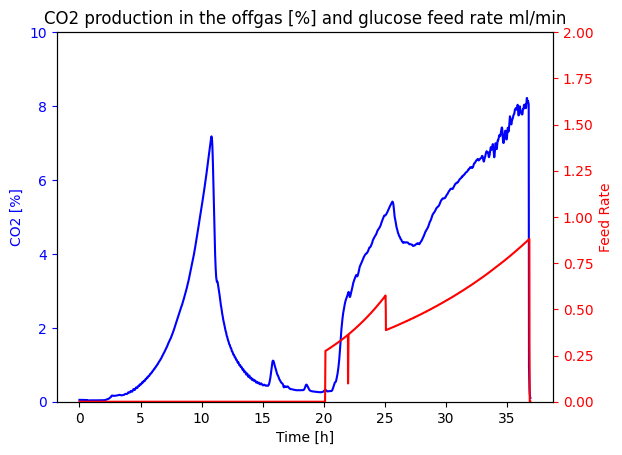

In [205]:
# Read the data from the Excel file
df_Sensor = pd.read_excel('raw data/Sensor_extracted_values.xlsx')

# Extract the relevant columns
time1 = df_Offgas['Time [h]']
time2 = df['time [h]']
O2 = df_Offgas['CO2 [%]']
Feedrate = df['real Feed']

# Create the plot
fig, ax1 = plt.subplots()

# Plot CO2 on the primary y-axis
ax1.plot(time1, O2, color='blue')
ax1.set_xlabel('Time [h]')
ax1.set_ylabel('CO2 [%]', color='blue')
ax1.tick_params('y', colors='blue')

# Create the secondary y-axis for feed rate
ax2 = ax1.twinx()
ax2.plot(time2, Feedrate, color='red')
ax2.set_ylabel('Feed Rate', color='red')
ax2.tick_params('y', colors='red')

# Set plot title and adjust y-axis limits
plt.title('CO2 production in the offgas [%] and glucose feed rate ml/min')
ax1.set_ylim(0, 10)
ax2.set_ylim(0, 2)  # Adjust the limits as needed for the feed rate

# Display the plot
plt.show()

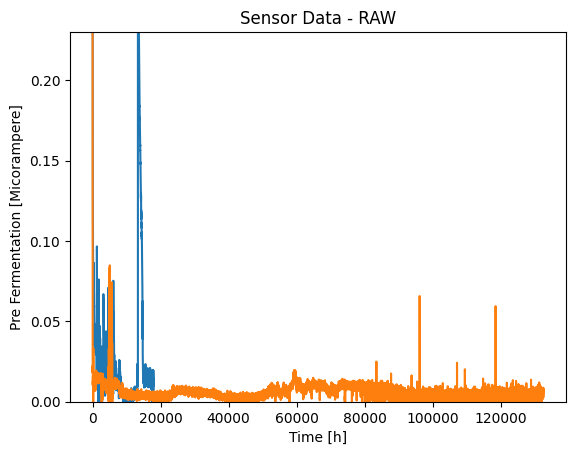

In [206]:
df_Sensor = pd.read_excel('raw data/Sensor_extracted_values.xlsx')

# Extract the 'time [h]' and 'pre fermentation [Ampere]' columns
time = df_Sensor['time [h]']
pre_fermentation =df_Sensor['pre fermentation [Ampere]']
fermentation = df_Sensor['fermentation [Ampere]']

# Create the plot
plt.plot(time, pre_fermentation)
plt.plot(time, fermentation)
plt.xlabel('Time [h]')
plt.ylabel('Pre Fermentation [Micorampere]')
plt.title('Sensor Data - RAW')
plt.ylim(0,0.23)

# Display the plot
plt.show()

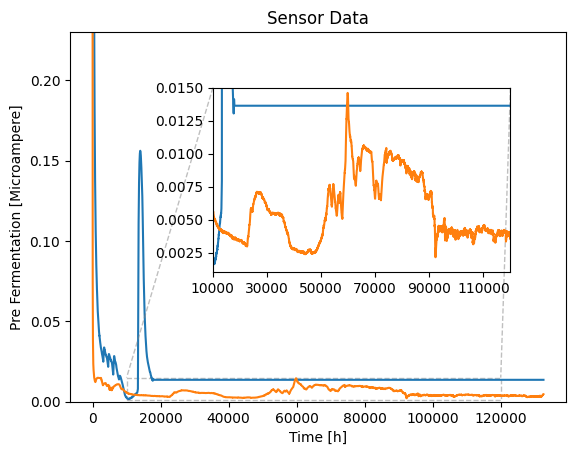

In [207]:
df_Sensor = pd.read_excel('raw data/Sensor_extracted_values.xlsx')

# Extract the 'time [h]' and 'pre fermentation [Ampere]' columns
time = df_Sensor['time [h]']

pre_fermentation =df_Sensor_smoothed['pre fermentation [Ampere] - smoothed1']
fermentation = df_Sensor_smoothed['fermentation [Ampere] - smoothed2']

# Create the plot
fig, ax = plt.subplots()
ax.plot(time, pre_fermentation)
ax.plot(time, fermentation)
ax.set(xlabel = 'Time [h]', ylabel= 'Pre Fermentation [Microampere]', title = 'Sensor Data', ylim = (0,0.23), )

# second plot


axins = inset_axes(ax, "60%", "50%", loc = "upper right", borderpad = 4)
axins.plot(time, pre_fermentation)
axins.plot(time, fermentation)

axins.set(xlabel="", ylabel="", ylim= (0.001,0.015), xlim=(10000, 120000), xticks=list(range(10000,120000,20000)))

mark_inset(ax, axins, loc1=1, loc2 =2, fc = "none", ec="0.5", ls = "--", alpha= 0.5)


# Display the plot
plt.show()


#### calibration sensor 

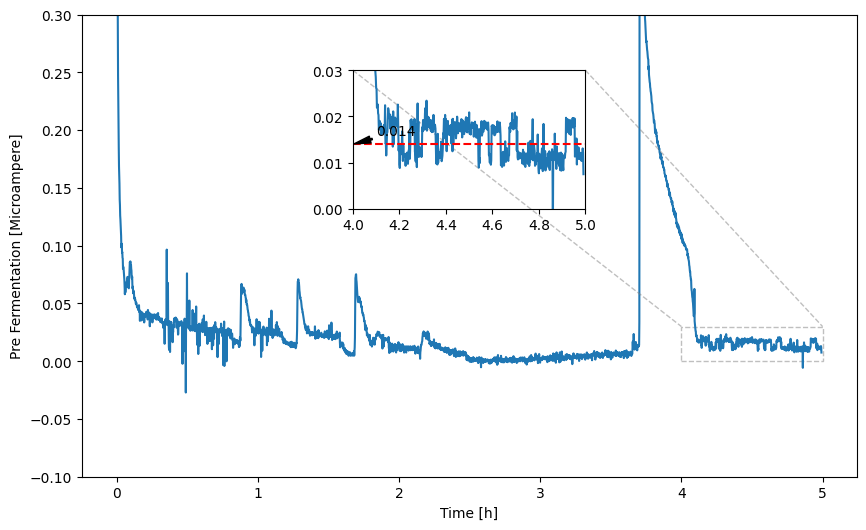

In [208]:
# Extract the 'time [h]' and 'pre fermentation [Ampere]' columns
time = df_Sensor_smoothed['Time[h]']
pre_fermentation = df_Sensor_smoothed['pre fermentation [Ampere]']

# Create the main plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time, pre_fermentation)
ax.set_ylim(-0.1, 0.3)

# Create the inset plot
axins = inset_axes(ax, "30%", "30%", loc="upper center", borderpad=4)
axins.plot(time, pre_fermentation)
axins.set(xlabel="", ylabel="", ylim=(0.0, 0.03), xlim=(4, 5))

# Mark the region of the inset plot on the main plot
mark_inset(ax, axins, loc1=1, loc2=2, fc="none", ec="0.5", ls="--", alpha=0.5)

# Add the red line at y-axis value 0.014 to the inset plot
axins.axhline(y=0.014, color='red', linestyle='--')

ax.set(xlabel = 'Time [h]', ylabel= 'Pre Fermentation [Microampere]' )

# Annotate the point at y-axis with the value 0.014
axins.annotate('0.014', xy=(4, 0.014), xytext=(4.1, 0.016),
               arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))

# Display the plot
plt.show()

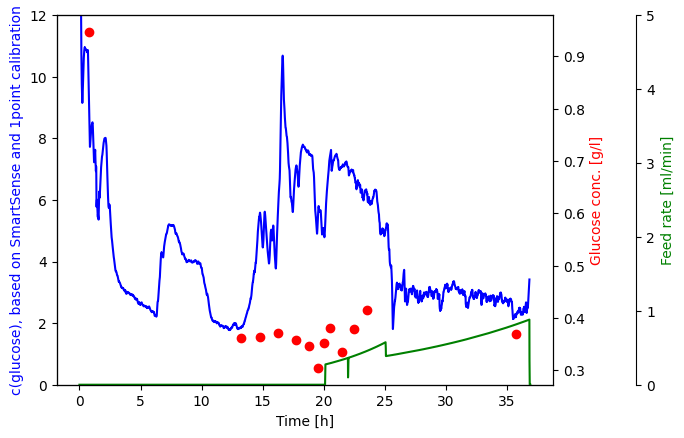

In [209]:


# Extract the 'time [h]' and 'pre fermentation [Ampere]' columns
time = df_Sensor_smoothed['Time[h]']
Current = df_Sensor_smoothed['Current to Concentration-smoothed']

# Create the plot and the first y-axis
fig, ax1 = plt.subplots()

# Plot the first dataset (Current to Concentration)
ax1.plot(time, Current, color='blue')
ax1.set_xlabel('Time [h]')
ax1.set_ylabel('c(glucose), based on SmartSense and 1point calibration', color='blue')
ax1.set_ylim(0, 12)  # Set the y-axis limits for the first plot

# Create a second y-axis and plot the second dataset (Glucose conc.)
ax2 = ax1.twinx()
ax2.scatter(df['time [h]'], df['glucose [g/l] '], color='red')
ax2.set_ylabel('Glucose conc. [g/l]', color='red')

# Create a third y-axis and plot the third dataset (Real Feed)
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Adjust the position of the third axis
ax3.plot(df['time [h]'], df['real Feed'], color='green')
ax3.set_ylabel('Feed rate [ml/min]', color='green')
ax3.set_ylim(0, 5) 

# Add a title to the plot

# Display the plot
plt.show()



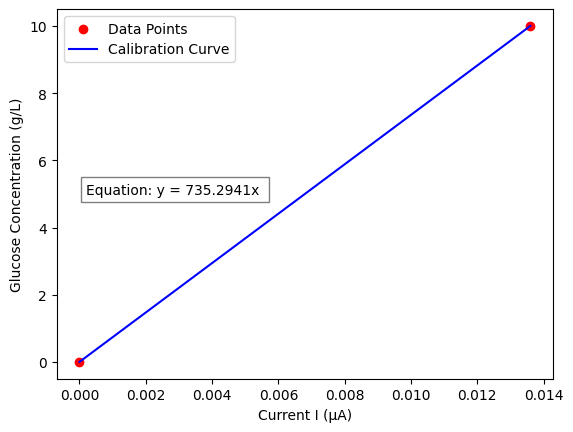

In [210]:
import numpy as np
import matplotlib.pyplot as plt

# Data points: glucose concentration (g/L) and corresponding microampere readings
glucose_concentration = np.array([0, 10])
microampere_readings = np.array([0, 0.0136])

# Perform a linear fit (1st order polynomial) to get calibration curve parameters
fit_params = np.polyfit(microampere_readings, glucose_concentration, 1)
calibration_curve = np.poly1d(fit_params)

# Calculate R-squared (coefficient of determination)
residuals = glucose_concentration - calibration_curve(microampere_readings)
SS_res = np.sum(residuals ** 2)
SS_tot = np.sum((glucose_concentration - np.mean(glucose_concentration)) ** 2)
r_squared = 1 - (SS_res / SS_tot)

# Plot the data points and calibration curve
plt.scatter(microampere_readings, glucose_concentration, label='Data Points', color = 'red')
plt.plot(microampere_readings, calibration_curve(microampere_readings), '-', label='Calibration Curve', color = 'blue')
plt.xlabel('Current I (µA)')    # Changed x-axis label
plt.ylabel('Glucose Concentration (g/L)')  # Changed y-axis label
plt.legend()

# Display R-squared value and equation of the calibration curve on the graph
equation_text = f'Equation: y = {fit_params[0]:.4f}x '
plt.text(0.0002, 5, equation_text, bbox=dict(facecolor='white', alpha=0.5))

plt.show()
